# Human Activity Recognition #

**Importing Necessary Libraries**

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**Loading the combined test and train dataset**

In [170]:
train_data = os.path.join('../Combined/Train')
test_data = os.path.join('../Combined/Test')
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)
    

In [171]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(f"Shape of X_train = {x_train.shape}") 
print(f'Shape of y_train = {y_train.shape}')

x_test=np.array(x_test)
y_test=np.array(y_test)
print(f"Shape of X_test = {x_test.shape}")
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (126, 500, 3)
Shape of y_train = (126,)
Shape of X_test = (54, 500, 3)
Shape of y_test = (54,)


**Task 1 - Question 1**

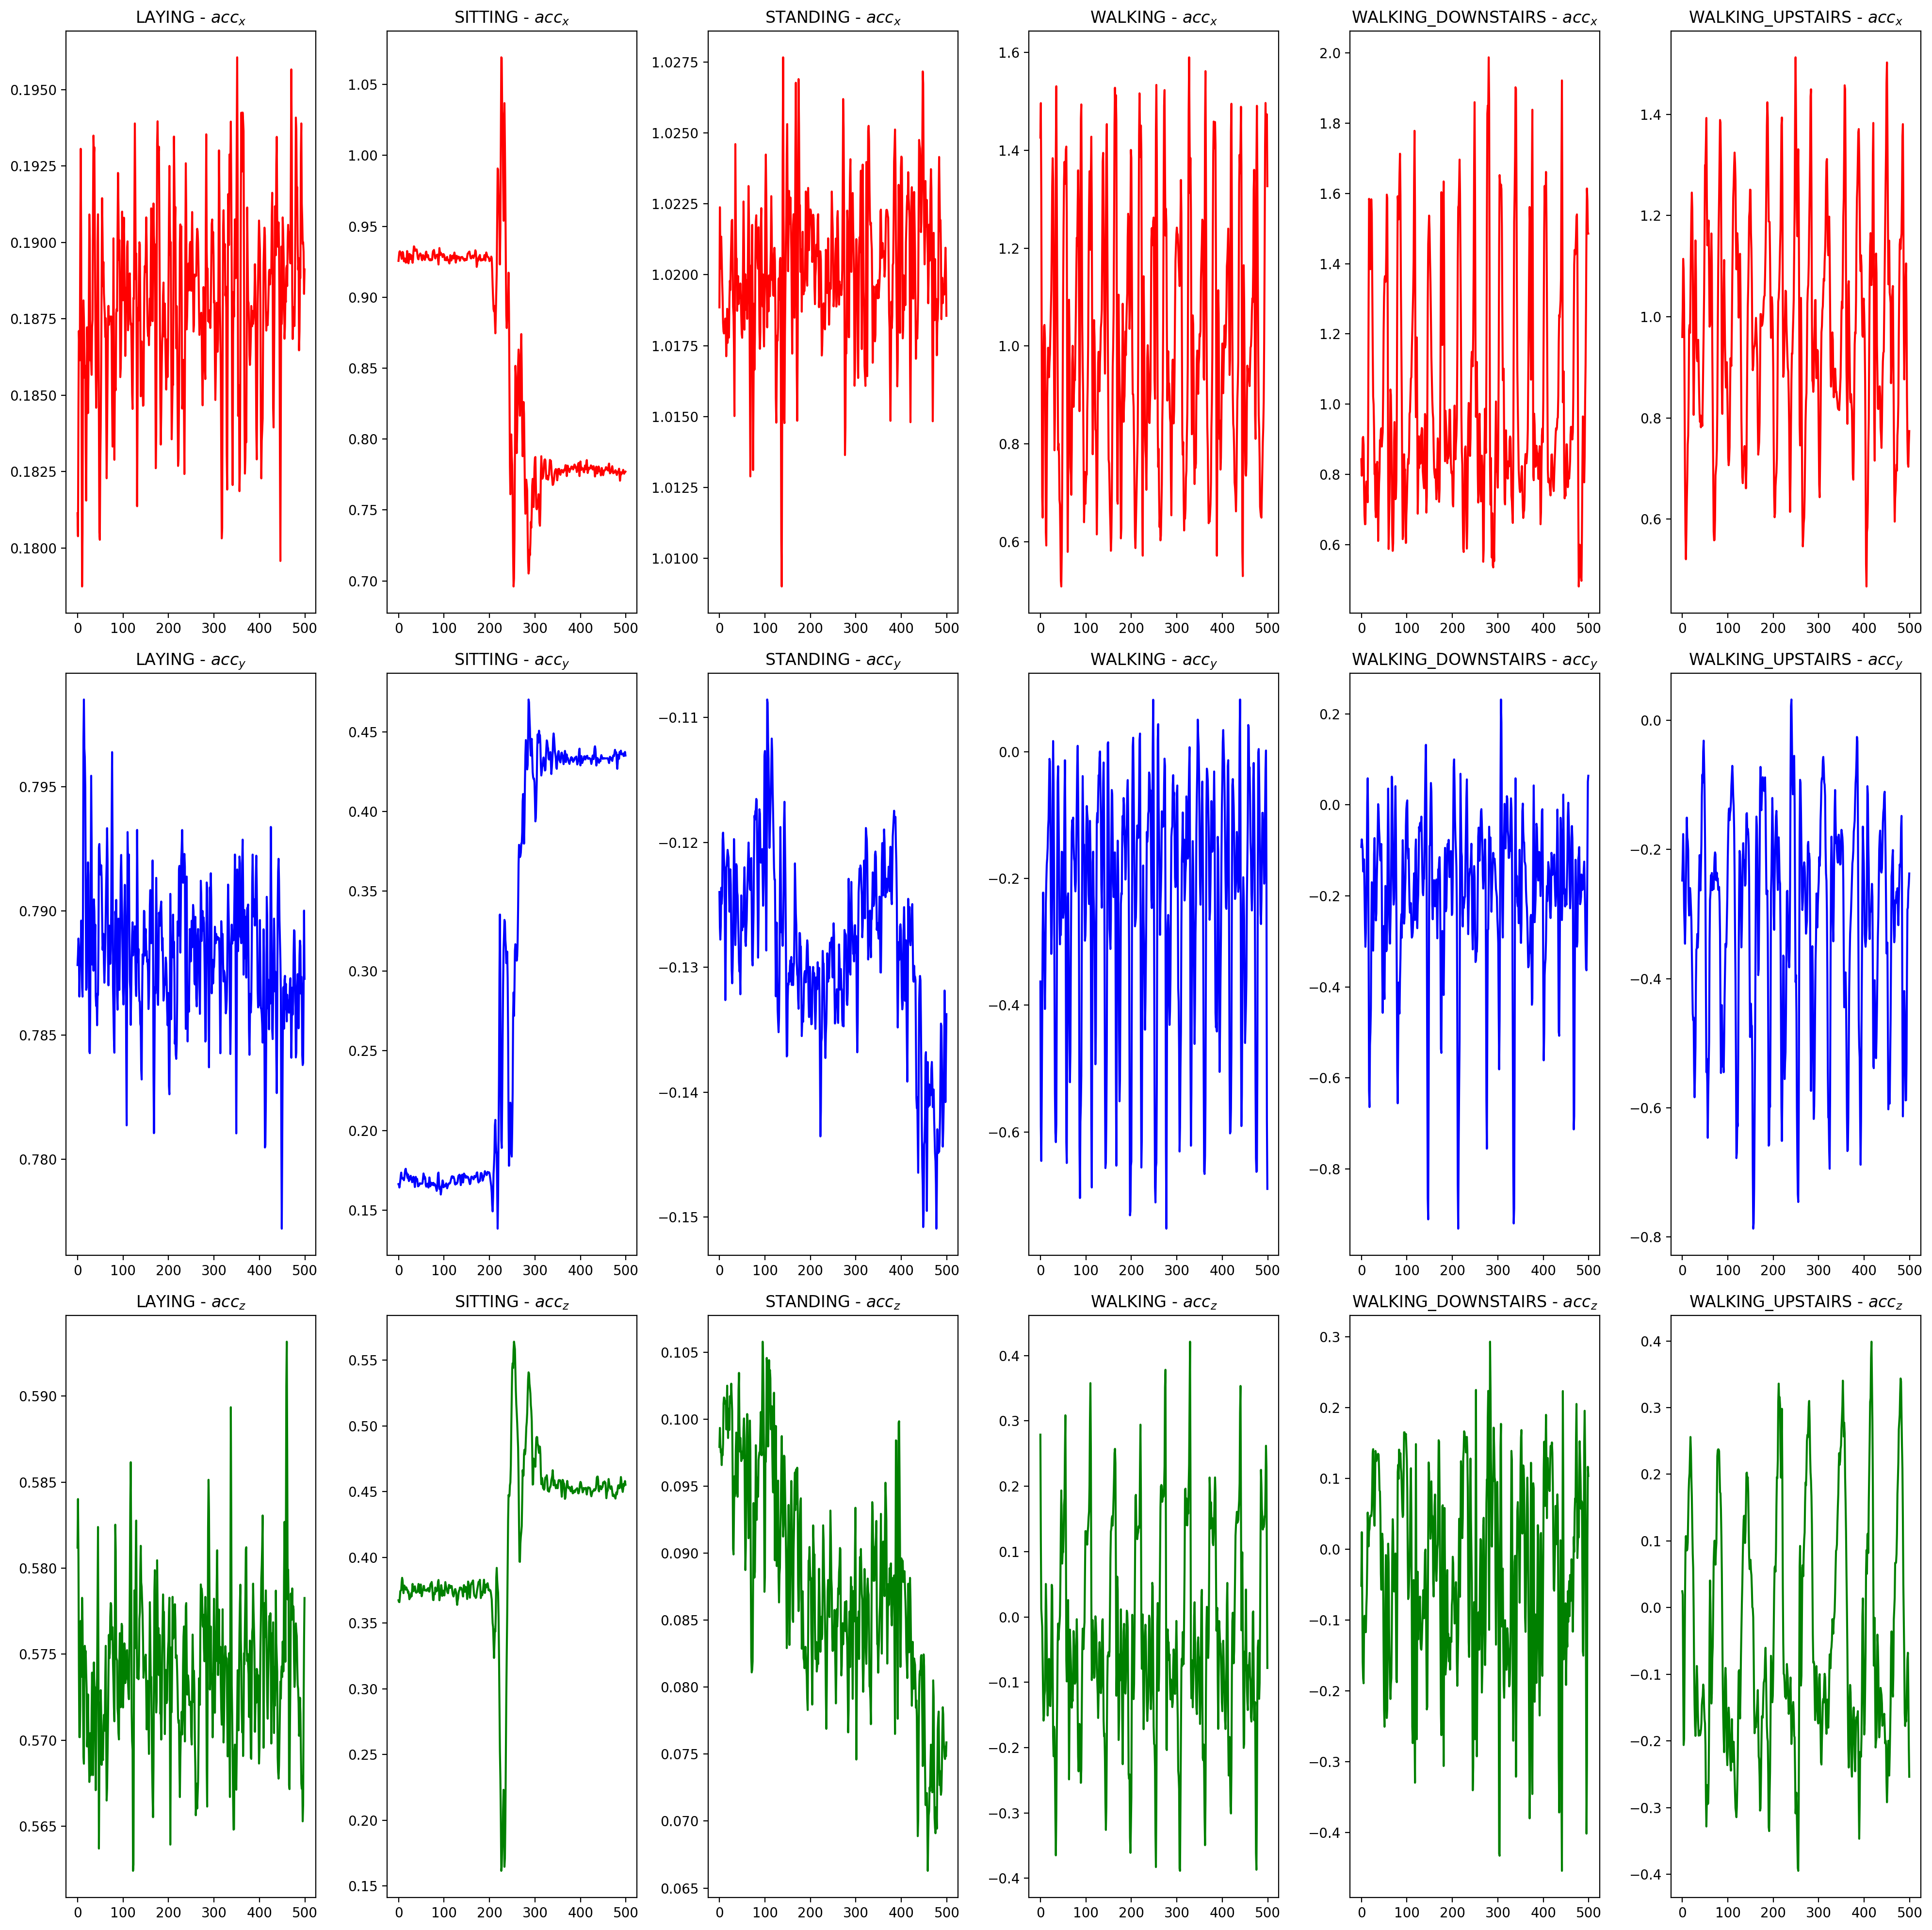

In [172]:
plt.figure(figsize=(20, 20))
axes = ['acc_x', 'acc_y', 'acc_z']
colors = ['r', 'b', 'g']

for i in range(6):
    activity = activities[i]
    data = x_train[i*21]  
    
    for j, (axis, color) in enumerate(zip(axes, colors)):
        plt.subplot(3, 6, i + 1 + j*6)
        plt.plot(np.arange(500), data[:, j], c=color)
        plt.title(f"{activity} - ${axis}$")
plt.tight_layout()
plt.show()

The following were the similaritis/differences observed in the plots:

1. Static activities like laying, sitting and standing show negligibly dyanamic signals nearly being flat, whereas the dyanamic activites like walking, walking upstairs and walking downstairs show repeatitive oscillations.
2. The value of acceleration (in any directions) along the static activities vary largely as for example acc_x vary from 0.18 to 0.19 for laying, 0.15 to 0.55 for sitting and 0.06 to 0.15 for standing, whereas represent a roughly constant range for dyanamic activities from -0.4 to 0.3.

It is easier for the model to distinguish between static and dyanamic class of activities but might be harder for the model to distinguish internally between them.

**Task 1 - Question 2**

For performing the task computing the value of mean total linear acceleration magnitude and the variance to see whether this
itself distinguishes the activities or a machine learning model is needed.


In [173]:
total_acceleration_train = (
    x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2
)

for i, activity in enumerate(activities):
    acc_mag = total_acceleration_train[i*21]   
    mean_ = acc_mag.mean()
    var_ = acc_mag.var()
    print(f"Activity: {activity}")
    print(f"  Mean total acceleration: {mean_:.4f}")
    print(f"  Variance: {var_:.6f}")


Activity: LAYING
  Mean total acceleration: 0.9860
  Variance: 0.000028
Activity: SITTING
  Mean total acceleration: 1.0156
  Variance: 0.001320
Activity: STANDING
  Mean total acceleration: 1.0651
  Variance: 0.000025
Activity: WALKING
  Mean total acceleration: 1.1896
  Variance: 0.341731
Activity: WALKING_DOWNSTAIRS
  Mean total acceleration: 1.2048
  Variance: 0.658302
Activity: WALKING_UPSTAIRS
  Mean total acceleration: 1.1484
  Variance: 0.229981


From the data:

1. Static activities show less variance in linear acceleration due to less body movements.
2. Dyanamic activities show relatively higher variance in linear acceleration due to more body movements.

Therefore just a threshold value of variance could classify between the two and explicitly a machine learning model is not required for the same.

**Task 1 - Question 3**

Calculating the shape of test and train total linear acceleration.

In [174]:
total_acceleration_test = x_test[:, :, 0]**2 + x_test[:, :, 1]**2 + x_test[:, :, 2]**2


print("Train total acceleration shape:", total_acceleration_train.shape)
print("Test total acceleration shape:", total_acceleration_test.shape)

Train total acceleration shape: (126, 500)
Test total acceleration shape: (54, 500)


Performing PCA on the training and test total acceleration:

In [175]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(total_acceleration_train)

pca_train = pca.transform(total_acceleration_train)        

print("PCA train_total acceleration shape:", pca_train.shape)


PCA train_total acceleration shape: (126, 2)


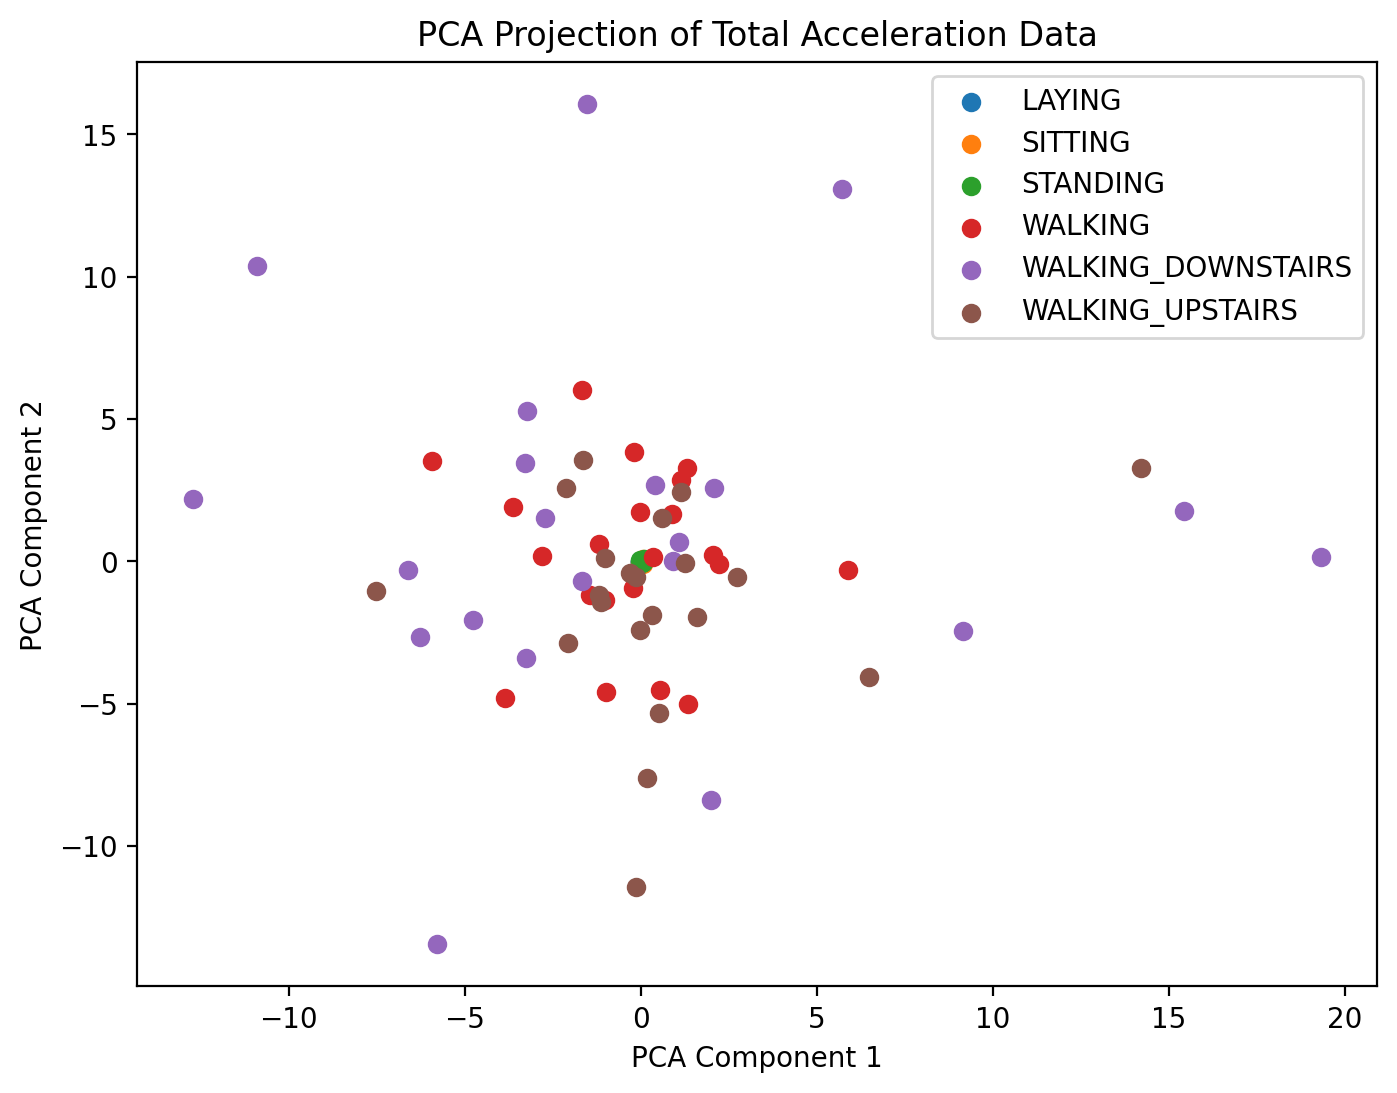

In [176]:
plt.figure(figsize=(8, 6))

for i, activity in enumerate(activities):
    start_idx = i * 21   
    end_idx = (i + 1) * 21
    
    plt.scatter(
        pca_train[start_idx:end_idx, 0],
        pca_train[start_idx:end_idx, 1],
        label=activity
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Total Acceleration Data")
plt.legend()
plt.show()


Using **TSEFL** to create new feautures and then performing PCA on it.

In [177]:
!pip install tsfel

In [178]:
import tsfel
cfg = tsfel.get_features_by_domain()

In [179]:
def extract_features(data,fs=50):
    tsfel_features = []
    for i in range(len(data)):
        feature = tsfel.time_series_features_extractor(cfg, data[i], fs=50, verbose=0)
        tsfel_features.append(feature.values.flatten())
    
    return tsfel_features


In [180]:
tsfel_features_train=np.array(extract_features(total_acceleration_train))
tsfel_features_test=np.array(extract_features(total_acceleration_test))

print(tsfel_features_train.shape)
print(tsfel_features_test.shape)

(126, 156)
(54, 156)


In [181]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(tsfel_features_train)
tsfel_pca_data = pca.transform(tsfel_features_train)
tsfel_pca_data.shape

(126, 2)

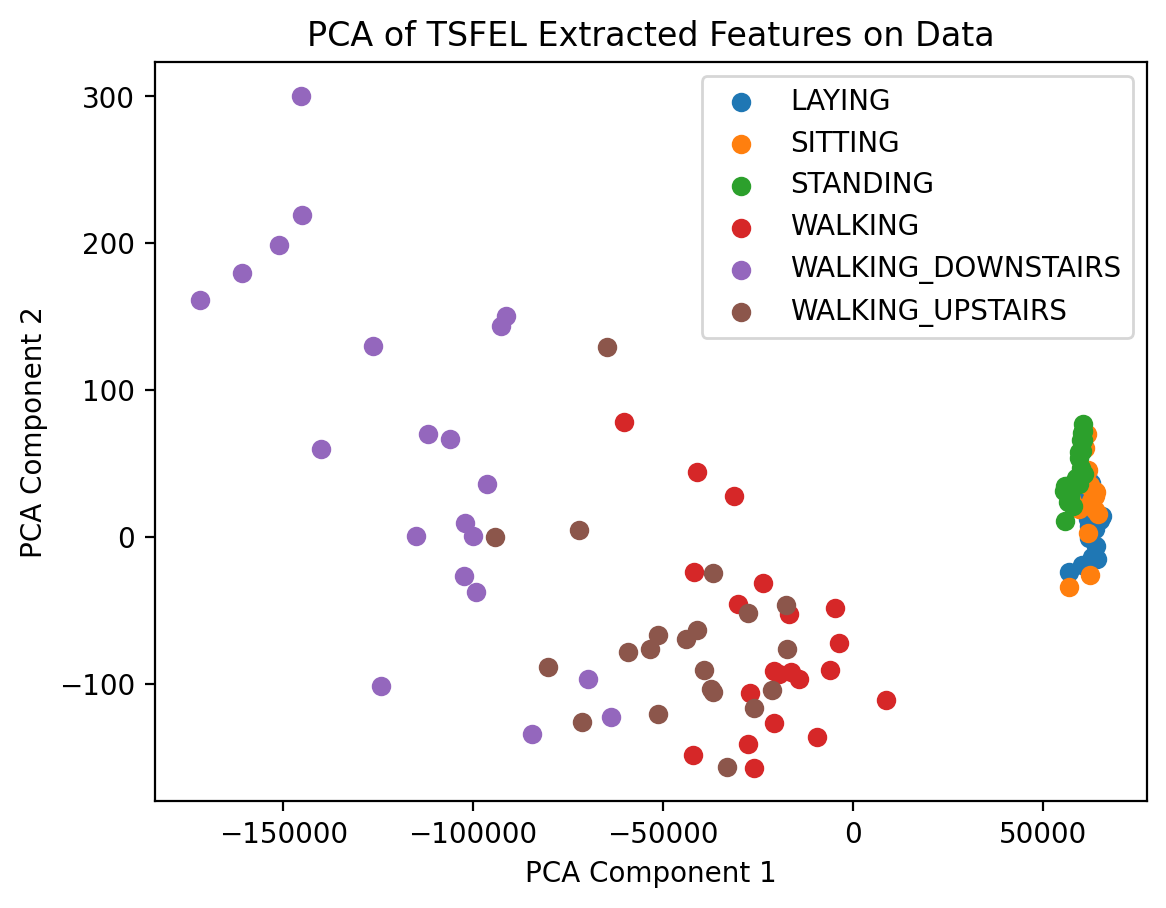

In [182]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(tsfel_pca_data[i*21:(i+1)*21,0], tsfel_pca_data[i*21:(i+1)*21,1], label=activity)
    
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of TSFEL Extracted Features on Data")
plt.show()    

**Performing PCA on the features provided by the dataset to obtain two features from it.**

In [183]:
X_train_features = np.loadtxt('UCI HAR Dataset/train/X_train.txt')
print(X_train_features.shape)

y_train_features = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
print(y_train_features.shape)

(7352, 561)
(7352,)


In [184]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_features)
X_train_pca_data = pca.transform(X_train_features)
X_train_pca_data.shape

(7352, 2)

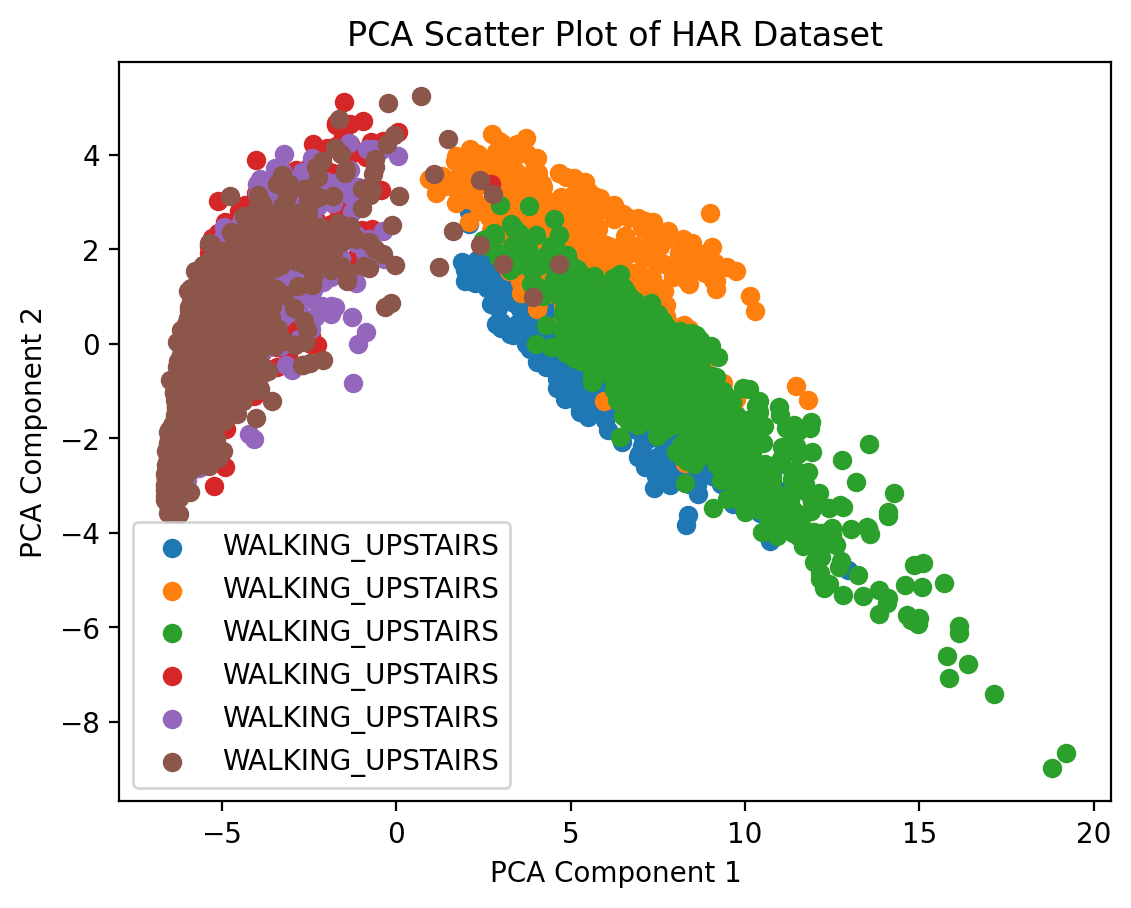

In [185]:
for i in range(1, 7):
    plt.scatter(
        X_train_pca_data[y_train_features == i, 0],
        X_train_pca_data[y_train_features == i, 1],
        label=activity
    )

plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Scatter Plot of HAR Dataset")
plt.show()


Following were the observations noted after plotting the all three plots:

1. PCA on total acceleration was have activities overlapping and more scattered. No such clusters were formed.
2. PCA on the TSFEL features have clearer distinction between the static and dyanamic group of activities but posses some internal overlapping for dyanamic activities.
3. PCA on dataset features gave clear separations among the activities internally as well, where activities are forming different clusters.

**Task 1 - Question 4**

In [186]:
import pandas as pd

sample_features = tsfel.time_series_features_extractor(cfg, total_acceleration_train[0], verbose=0)
tsfel_feature_names = sample_features.columns

tsfel_features_train_df = pd.DataFrame(tsfel_features_train, columns=tsfel_feature_names)
tsfel_features_train_df.columns = tsfel_features_train_df.columns.str.replace(r"^0_", "", regex=True)

tsfel_corr = tsfel_features_train_df.corr()
tsfel_corr

C:\Users\anujj\AppData\Local\Temp\ipykernel_43504\681775531.py:3: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, total_acceleration_train[0], verbose=0)


,Absolute energy,Area under the curve,Autocorrelation,Average power,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,...,Wavelet variance_1.39Hz,Wavelet variance_1.56Hz,Wavelet variance_1.79Hz,Wavelet variance_12.5Hz,Wavelet variance_2.08Hz,Wavelet variance_2.5Hz,Wavelet variance_3.12Hz,Wavelet variance_4.17Hz,Wavelet variance_6.25Hz,Zero crossing rate
Absolute energy,1.000000,0.958144,-0.074475,1.000000,0.193766,NaN,NaN,-0.926880,0.961725,NaN,...,0.941081,0.969189,0.980580,0.929534,0.979763,0.974545,0.971304,0.966689,0.957283,NaN
Area under the curve,0.958144,1.000000,-0.091031,0.958144,0.157284,NaN,NaN,-0.928568,0.964871,NaN,...,0.883263,0.902638,0.906703,0.881627,0.899651,0.887853,0.875166,0.862845,0.868481,NaN
Autocorrelation,-0.074475,-0.091031,1.000000,-0.074475,-0.030978,NaN,NaN,0.057230,-0.068681,NaN,...,-0.060595,-0.060720,-0.060064,-0.075360,-0.059174,-0.058641,-0.058747,-0.060505,-0.068533,NaN
Average power,1.000000,0.958144,-0.074475,1.000000,0.193766,NaN,NaN,-0.926880,0.961725,NaN,...,0.941081,0.969189,0.980580,0.929534,0.979763,0.974545,0.971304,0.966689,0.957283,NaN
Centroid,0.193766,0.157284,-0.030978,0.193766,1.000000,NaN,NaN,-0.170841,0.206578,NaN,...,0.243126,0.254164,0.249636,0.082323,0.235012,0.219700,0.212616,0.202888,0.152745,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wavelet variance_2.5Hz,0.974545,0.887853,-0.058641,0.974545,0.219700,NaN,NaN,-0.879711,0.928454,NaN,...,0.902949,0.951702,0.982156,0.881021,0.996644,1.000000,0.996640,0.980196,0.936339,NaN
Wavelet variance_3.12Hz,0.971304,0.875166,-0.058747,0.971304,0.212616,NaN,NaN,-0.860440,0.912485,NaN,...,0.893777,0.941949,0.972933,0.891207,0.989365,0.996640,1.000000,0.991984,0.953192,NaN
Wavelet variance_4.17Hz,0.966689,0.862845,-0.060505,0.966689,0.202888,NaN,NaN,-0.840875,0.888402,NaN,...,0.895366,0.935711,0.959972,0.910608,0.972197,0.980196,0.991984,1.000000,0.979065,NaN
Wavelet variance_6.25Hz,0.957283,0.868481,-0.068533,0.957283,0.152745,NaN,NaN,-0.840667,0.865245,NaN,...,0.889960,0.916458,0.928409,0.956599,0.931590,0.936339,0.953192,0.979065,1.000000,NaN


In [187]:
features = np.loadtxt('UCI HAR Dataset/features.txt', dtype=str)
features = features[:, 1]  

dataset_features_train_df = pd.DataFrame(X_train_features, columns=features)


dataset_corr = dataset_features_train_df.corr()
dataset_corr 

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.030681,-0.017557,-0.015613,-0.544320,0.012173,0.037444,0.028844,-0.035257,0.034371,0.028242
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,-0.022395,-0.001587,-0.004459,0.070559,-0.013541,0.017967,0.075679,-0.005309,0.001053,-0.013903
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.020481,0.020091,0.019127,0.052841,-0.039836,-0.063609,-0.034037,0.008587,-0.015288,-0.022643
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.037444,0.017967,-0.063609,0.018985,-0.008507,-0.018429,0.019389,-0.012546,-0.023525,0.025066,...,-0.026615,0.034514,0.024553,-0.006269,0.009141,1.000000,-0.116001,-0.005853,-0.012313,-0.019903
"angle(tBodyGyroJerkMean,gravityMean)",0.028844,0.075679,-0.034037,-0.024810,-0.014592,-0.006471,-0.024951,-0.012341,-0.007231,-0.028871,...,0.000102,-0.017937,-0.014865,-0.020823,0.035263,-0.116001,1.000000,0.023995,-0.005869,-0.005656
"angle(X,gravityMean)",-0.035257,-0.005309,0.008587,-0.371653,-0.380531,-0.345011,-0.368191,-0.377025,-0.347389,-0.384192,...,0.087332,-0.086006,-0.079751,0.011880,0.023246,-0.005853,0.023995,1.000000,-0.783848,-0.643655
"angle(Y,gravityMean)",0.034371,0.001053,-0.015288,0.471065,0.523600,0.476006,0.466424,0.525081,0.477607,0.480229,...,-0.100125,0.086993,0.078079,0.001540,-0.012990,-0.012313,-0.005869,-0.783848,1.000000,0.594885


In [188]:
threshold = 0.95

corr_matrix_tsfel = tsfel_features_train_df.corr()
upper_tsfel = corr_matrix_tsfel.where(np.triu(np.ones(corr_matrix_tsfel.shape), k=1).astype(bool))

high_corr_tsfel = [column for column in upper_tsfel.columns if any(upper_tsfel[column].abs() > threshold)]

print("Highly correlated TSFEL features (possible redundancy):")
print(high_corr_tsfel)

Highly correlated TSFEL features (possible redundancy):
['Area under the curve', 'Average power', 'ECDF Percentile_1', 'Human range energy', 'Interquartile range', 'LPCC_0', 'LPCC_10', 'LPCC_11', 'LPCC_2', 'LPCC_4', 'LPCC_5', 'LPCC_6', 'LPCC_7', 'LPCC_8', 'LPCC_9', 'MFCC_0', 'Max', 'Mean', 'Mean absolute deviation', 'Mean absolute diff', 'Median absolute deviation', 'Median absolute diff', 'Median frequency', 'Min', 'Peak to peak distance', 'Positive turning points', 'Root mean square', 'Signal distance', 'Spectral centroid', 'Spectral distance', 'Spectral entropy', 'Spectral kurtosis', 'Spectral roll-off', 'Spectral skewness', 'Spectral slope', 'Spectral spread', 'Spectrogram mean coefficient_1.61Hz', 'Standard deviation', 'Sum absolute diff', 'Variance', 'Wavelet absolute mean_1.56Hz', 'Wavelet absolute mean_1.79Hz', 'Wavelet absolute mean_2.08Hz', 'Wavelet absolute mean_2.5Hz', 'Wavelet absolute mean_3.12Hz', 'Wavelet absolute mean_4.17Hz', 'Wavelet absolute mean_6.25Hz', 'Wavelet e

In [189]:
corr_matrix_dataset = dataset_features_train_df.corr()
upper_dataset = corr_matrix_dataset.where(np.triu(np.ones(corr_matrix_dataset.shape), k=1).astype(bool))
high_corr_dataset = [column for column in upper_dataset.columns if any(upper_dataset[column].abs() > threshold)]

print("\nHighly correlated dataset features (possible redundancy):")
print(high_corr_dataset)


Highly correlated dataset features (possible redundancy):
['tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tGravityAcc-mad()-X', 'tGravityAcc-mad()-Y', 'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-Z', 'tGravityAcc-energy()-X', 'tGravityAcc-iqr()-X', 'tGravityAcc-iqr()-Y', 'tGravityAcc-iqr()-Z', 'tGravityAcc-arCoeff()-X,2', 'tGravityAcc-arCoeff()-X,3', 'tGravityAcc-arCoeff()-X,4', 'tGravityAcc-arCoeff()-Y,2', 'tGravityAcc-arCoeff()-Y,3', 'tGravityAcc-arCoeff()-Y,4', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Z,3', 'tGravityAcc-arCoeff()-Z,4', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-mad()-Z', 'tBodyAccJerk-ma

**Task 2 - Question 1**

**Importing necessary libraries**

In [190]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

**Decision tree model using the raw accelerometer data**

Decision Tree Performance Metrics:
Accuracy   : 0.5556
Precision  : 0.5624
Recall     : 0.5556
F1 Score   : 0.5449


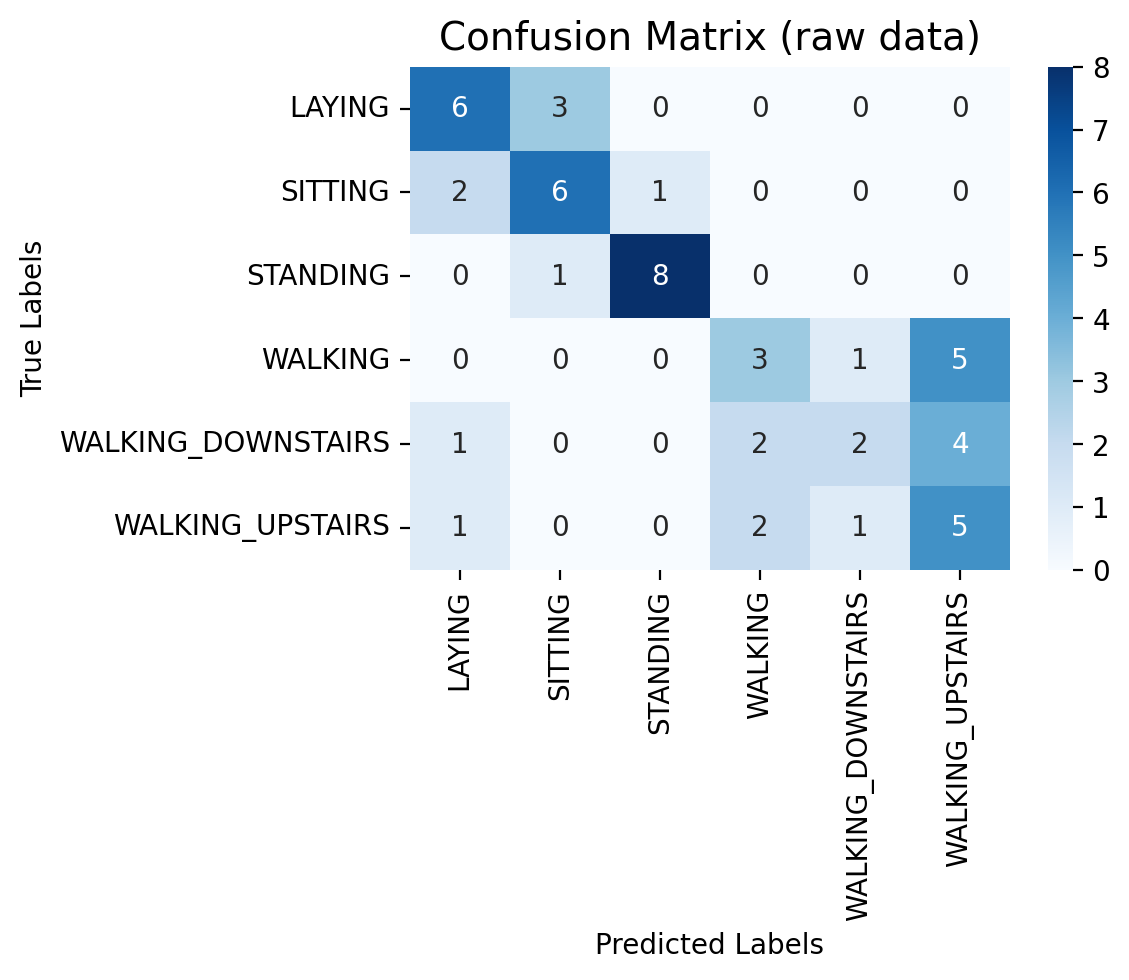

In [191]:
decision_tree_raw_data = DecisionTreeClassifier()   
decision_tree_raw_data.fit(total_acceleration_train, y_train)

y_pred_dt = decision_tree_raw_data.predict(total_acceleration_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt, average='weighted')
dt_recall = recall_score(y_test, y_pred_dt, average='weighted')
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')

print("Decision Tree Performance Metrics:")
print(f"Accuracy   : {dt_accuracy:.4f}")
print(f"Precision  : {dt_precision:.4f}")
print(f"Recall     : {dt_recall:.4f}")
print(f"F1 Score   : {dt_f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix (raw data)', fontsize=14)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

**Decision Tree Model using the TSFEL data**

 TSFEL Features - Decision Tree Performance Metrics:
Accuracy   : 0.6852
Precision  : 0.6953
Recall     : 0.6852
F1 Score   : 0.6866


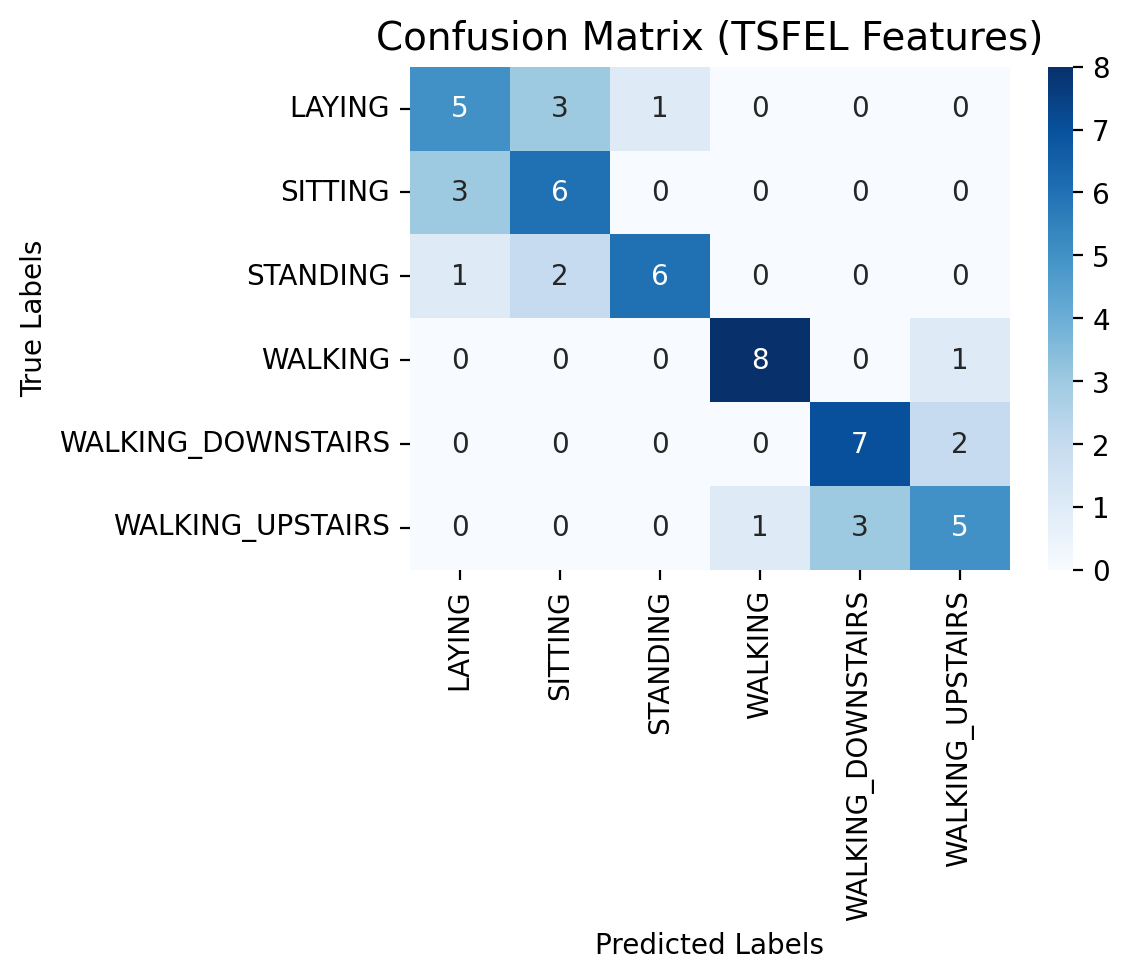

In [192]:
tsfel_decision_tree = DecisionTreeClassifier()   
tsfel_decision_tree.fit(tsfel_features_train, y_train)

y_pred_tsfel = tsfel_decision_tree.predict(tsfel_features_test)

tsfel_accuracy = accuracy_score(y_test, y_pred_tsfel)
tsfel_precision = precision_score(y_test, y_pred_tsfel, average='weighted')
tsfel_recall = recall_score(y_test, y_pred_tsfel, average='weighted')
tsfel_f1 = f1_score(y_test, y_pred_tsfel, average='weighted')

print(" TSFEL Features - Decision Tree Performance Metrics:")
print(f"Accuracy   : {tsfel_accuracy:.4f}")
print(f"Precision  : {tsfel_precision:.4f}")
print(f"Recall     : {tsfel_recall:.4f}")
print(f"F1 Score   : {tsfel_f1:.4f}")

conf_matrix_tsfel = confusion_matrix(y_test, y_pred_tsfel)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_tsfel, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix (TSFEL Features)', fontsize=14)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

**Decision Tree Model using features provided in the dataset**

Loading the test dataset:

In [193]:
X_test_features = np.loadtxt('UCI HAR Dataset/test/X_test.txt')
print(X_test_features.shape)

y_test_features = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
print(y_test_features.shape)

(2947, 561)
(2947,)


Forming the Decision Tree

Extracted Features - Decision Tree Performance Metrics:
Accuracy   : 0.8568
Precision  : 0.8573
Recall     : 0.8568
F1 Score   : 0.8563


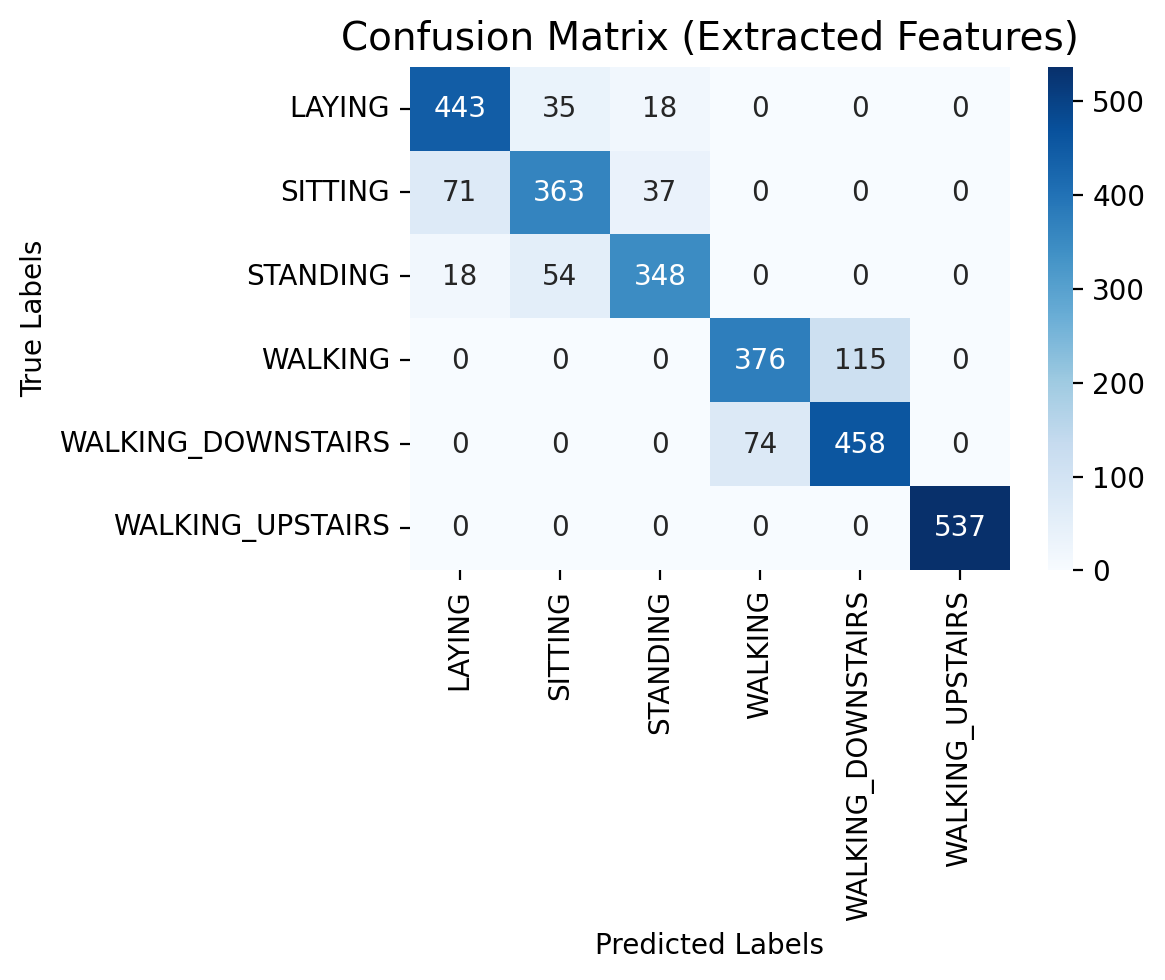

In [194]:
data_features_decision_tree = DecisionTreeClassifier()   
data_features_decision_tree.fit(X_train_features, y_train_features)

y_pred_features = data_features_decision_tree.predict(X_test_features)

features_accuracy = accuracy_score(y_test_features, y_pred_features)
features_precision = precision_score(y_test_features, y_pred_features, average='weighted')
features_recall = recall_score(y_test_features, y_pred_features, average='weighted')
features_f1 = f1_score(y_test_features, y_pred_features, average='weighted')

print("Extracted Features - Decision Tree Performance Metrics:")
print(f"Accuracy   : {features_accuracy:.4f}")
print(f"Precision  : {features_precision:.4f}")
print(f"Recall     : {features_recall:.4f}")
print(f"F1 Score   : {features_f1:.4f}")

conf_matrix_features = confusion_matrix(y_test_features, y_pred_features)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_features, annot=True, fmt='d', xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix (Extracted Features)', fontsize=14)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

The accuracies acheived of the three models are as follows:

1. Decision tree on raw accelerometer data - 0.46
2. Decision tree on TSFEL features data - 0.77
3. Decision tree on data features - 0.86

Therefore, based on accuracy as well as other listed metric the best model to use is the one trained on the dataset features.

**Task 2  - Question 2**

Training the all three decison tree models with varying depths.


Results for Raw Accelerometer Data:
Depth 2 : Accuracy = 0.4074
Depth 3 : Accuracy = 0.4630
Depth 4 : Accuracy = 0.5370
Depth 5 : Accuracy = 0.5556
Depth 6 : Accuracy = 0.5185
Depth 7 : Accuracy = 0.5185
Depth 8 : Accuracy = 0.5185

Results for TSFEL Features:
Depth 2 : Accuracy = 0.5926
Depth 3 : Accuracy = 0.7593
Depth 4 : Accuracy = 0.7407
Depth 5 : Accuracy = 0.7222
Depth 6 : Accuracy = 0.7222
Depth 7 : Accuracy = 0.7222
Depth 8 : Accuracy = 0.7222

Results for Provided Features:
Depth 2 : Accuracy = 0.5310
Depth 3 : Accuracy = 0.7224
Depth 4 : Accuracy = 0.8096
Depth 5 : Accuracy = 0.8385
Depth 6 : Accuracy = 0.8551
Depth 7 : Accuracy = 0.8639
Depth 8 : Accuracy = 0.8707


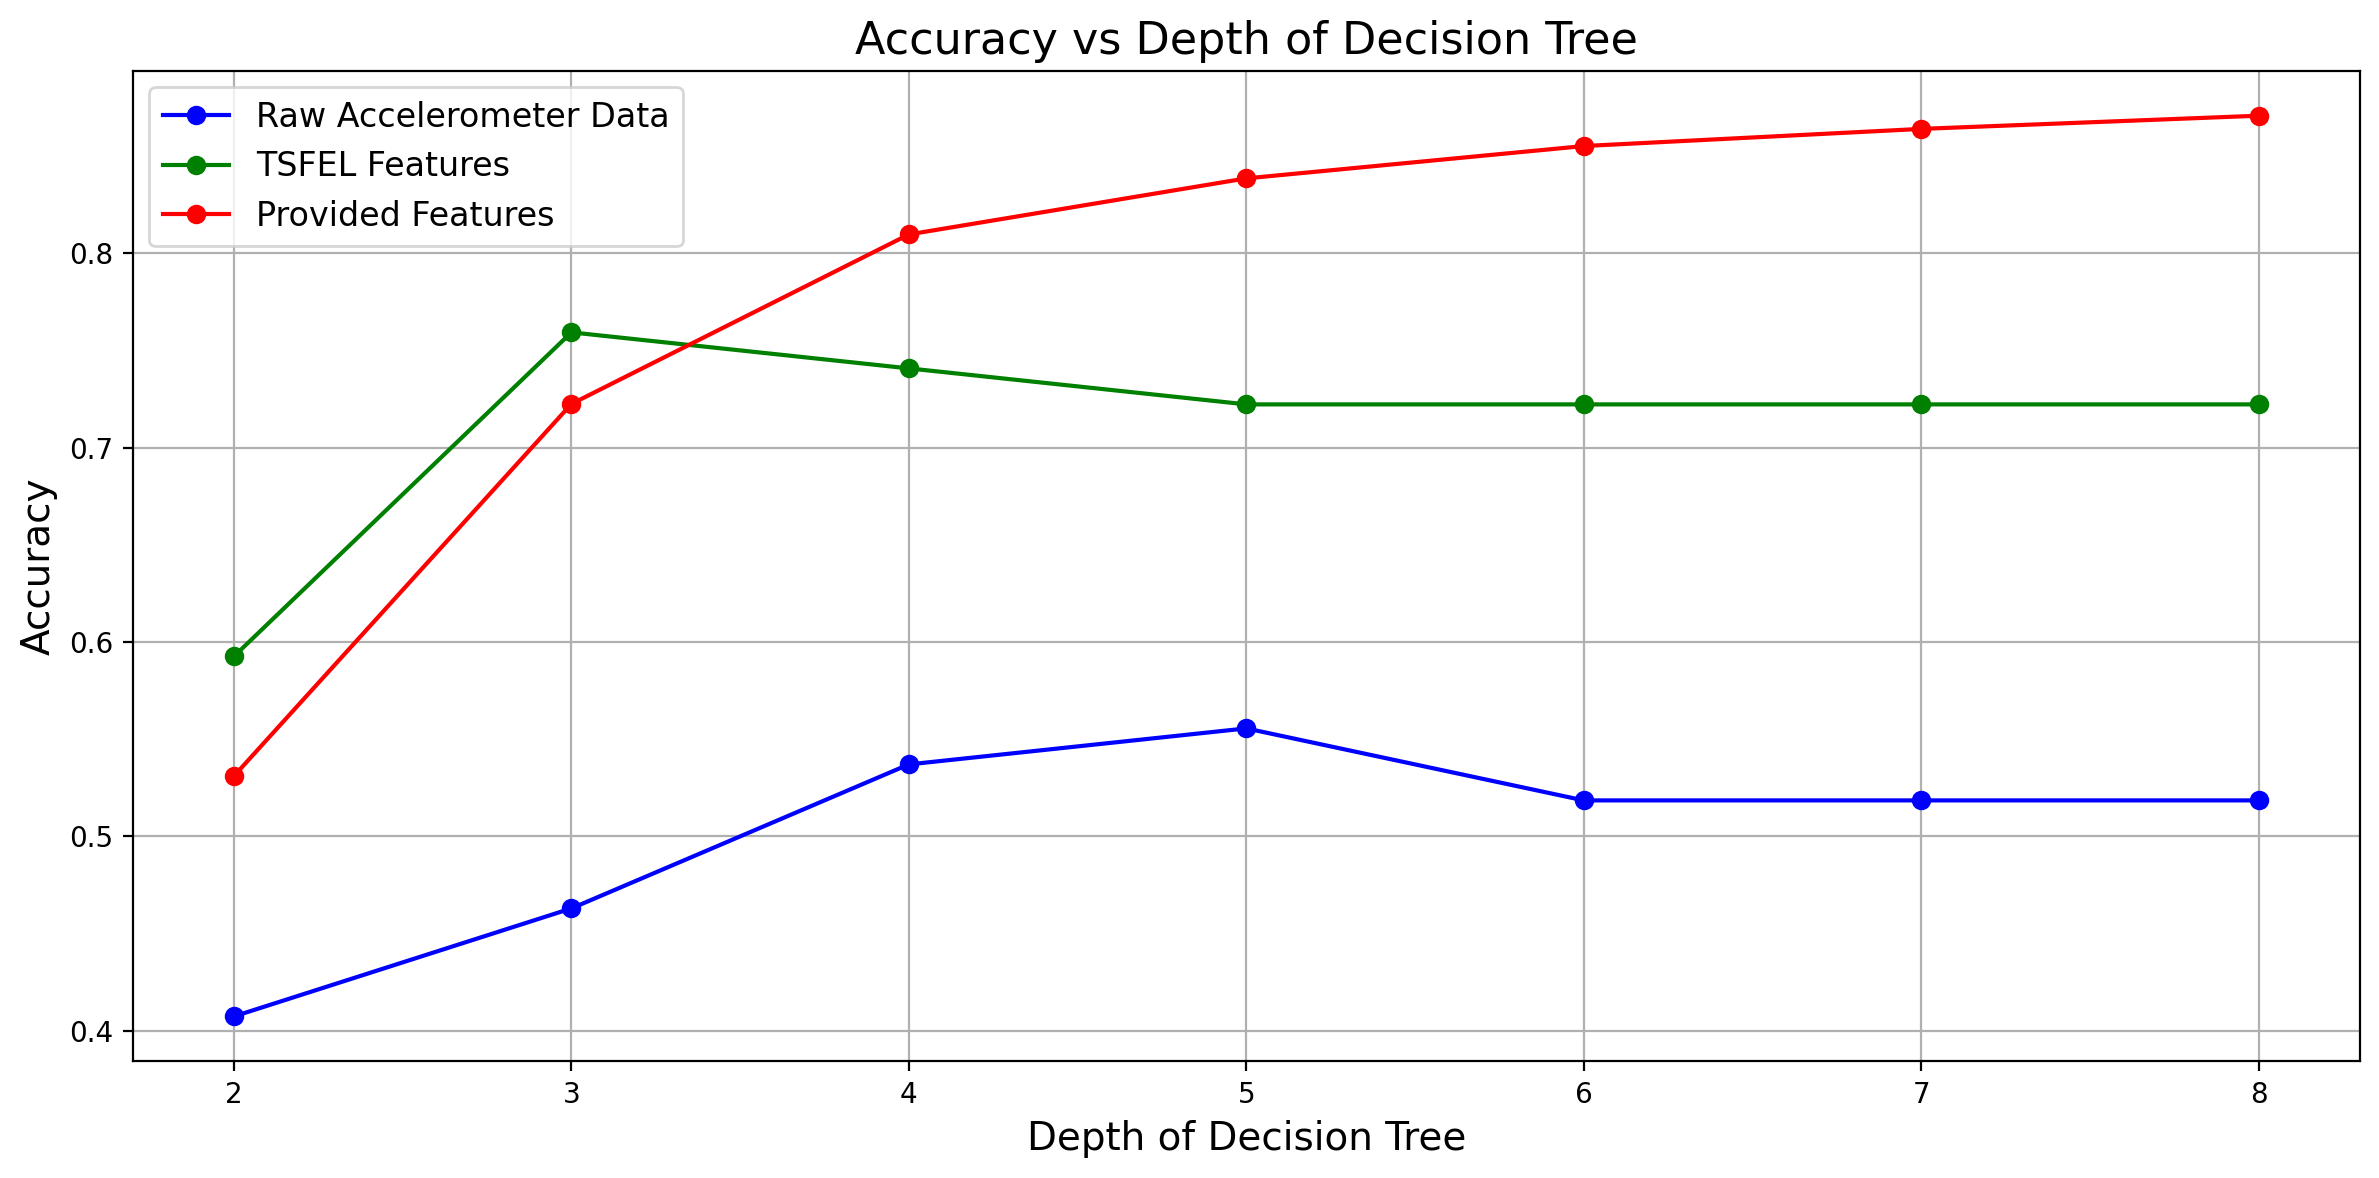

In [195]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depths = range(2, 9)

accuracies_raw = []
accuracies_tsfel = []
accuracies_features = []

def evaluate_dt(X_train, y_train, X_test, y_test, depths, label):
    acc_list = []
    print(f"\nResults for {label}:")
    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=0)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"Depth {depth:<2}: Accuracy = {acc:.4f}")
        acc_list.append(acc)
    return acc_list

accuracies_raw = evaluate_dt(total_acceleration_train, y_train, total_acceleration_test, y_test, depths, "Raw Accelerometer Data")
accuracies_tsfel = evaluate_dt(tsfel_features_train, y_train, tsfel_features_test, y_test, depths, "TSFEL Features")
accuracies_features = evaluate_dt(X_train_features, y_train_features, X_test_features, y_test_features, depths, "Provided Features")

plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_raw, marker='o', linestyle='-', color='b', label='Raw Accelerometer Data')
plt.plot(depths, accuracies_tsfel, marker='o', linestyle='-', color='g', label='TSFEL Features')
plt.plot(depths, accuracies_features, marker='o', linestyle='-', color='r', label='Provided Features')

plt.xlabel('Depth of Decision Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Depth of Decision Tree', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


**Task 2 - Question 3**

1. Model trained using Raw Accelerometer Data:

The model trained using raw accelerometer data performs poorly compared to the other two models. From the confusion matrix, we can observe that it struggles significantly to distinguish between dynamic activities like walking, walking upstairs and walking downstairs, with frequent misclassifications among these activities. It also faces confusion between static activities like laying and sitting. This is because the raw accelerometer data has limited features, causing the model to underfit and lack the discriminative power needed to capture subtle differences between similar activities.

2. Model trained using TSFEL Features:

The model trained using TSFEL features performs well despite the small dataset size. It demonstrates superior classification ability across all activity types, with minimal confusion between classes. The model performs good in distinguishing dynamic activities and shows only slight confusion between similar static activities. This performance is because TSFEL features, derived through automated feature extraction processes, provide a comprehensive set of distinctive temporal and statistical characteristics that enable precise differentiation between various human activities.

3. Model trained on Extracted Features Dataset:

The model trained using extracted features from the larger dataset performs very well overall, achieving excellent results for most activities including perfect classification for walking upstairs. However, it faces some confusion between static activities and moderate confusion among walking variants. Despite having a significantly larger training dataset, its performance is comparable to the TSFEL model, indicating that quality feature can be as effective as large data volumes for activity recognition tasks.

**Task 3 - Question 1**

In [196]:
import os
print(os.getcwd())


c:\Users\anujj\OneDrive\Documents\ES-335--Assignment-1\HAR


In [197]:
recorded_folder_path = os.path.join('Recorded_dataset')
csv_files = os.listdir(recorded_folder_path)
X_train = []
X_total_acceleration = []
y = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", 
     "SITTING", "STANDING", "LAYING"]* 3

for csv in csv_files:
    df = pd.read_csv(os.path.join(recorded_folder_path, csv), delimiter=',', header=0)
    X_train.append(df.values[50:550, 1:4])
    X_total_acceleration.append(df.values[50:550, 4])
    


In [ ]:
print("Shape of X_total_acceleration:", np.array(X_total_acceleration).shape)
print("Expected shape (n_samples, n_features):", decision_tree_raw_data.n_features_in_)

Shape of X_total_acceleration: (18, 500)
Expected shape (n_samples, n_features): 500


Accuracy = 0.2777777777777778
Precision = 0.14761904761904765
Recall = 0.2777777777777778
F1 Score = 0.19166666666666668


c:\Users\anujj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


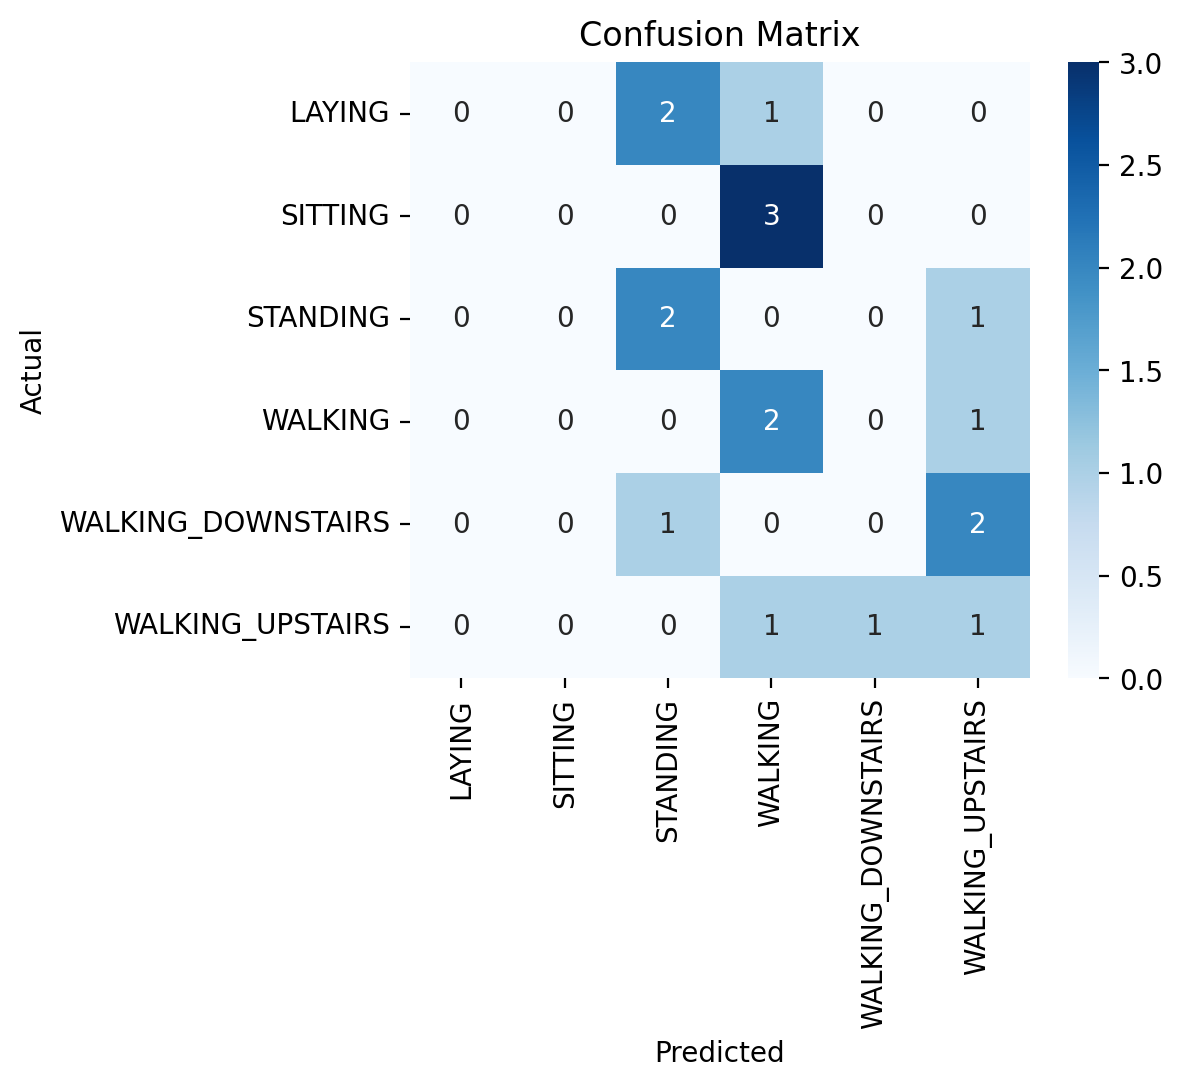

In [ ]:
recorded_tsfel_features = extract_features(X_total_acceleration)
recorded_tsfel_prediction = tsfel_decision_tree.predict(recorded_tsfel_features)
print(f"Accuracy = {accuracy_score(y,recorded_tsfel_prediction)}")
print(f"Precision = {precision_score(y,recorded_tsfel_prediction,average='weighted')}")
print(f"Recall = {recall_score(y,recorded_tsfel_prediction,average='weighted')}")
print(f"F1 Score = {f1_score(y,recorded_tsfel_prediction,average='weighted')}")
cm = confusion_matrix(y,recorded_tsfel_prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy = 0.1111111111111111
Precision = 0.058333333333333334
Recall = 0.1111111111111111
F1 Score = 0.07326007326007326


c:\Users\anujj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


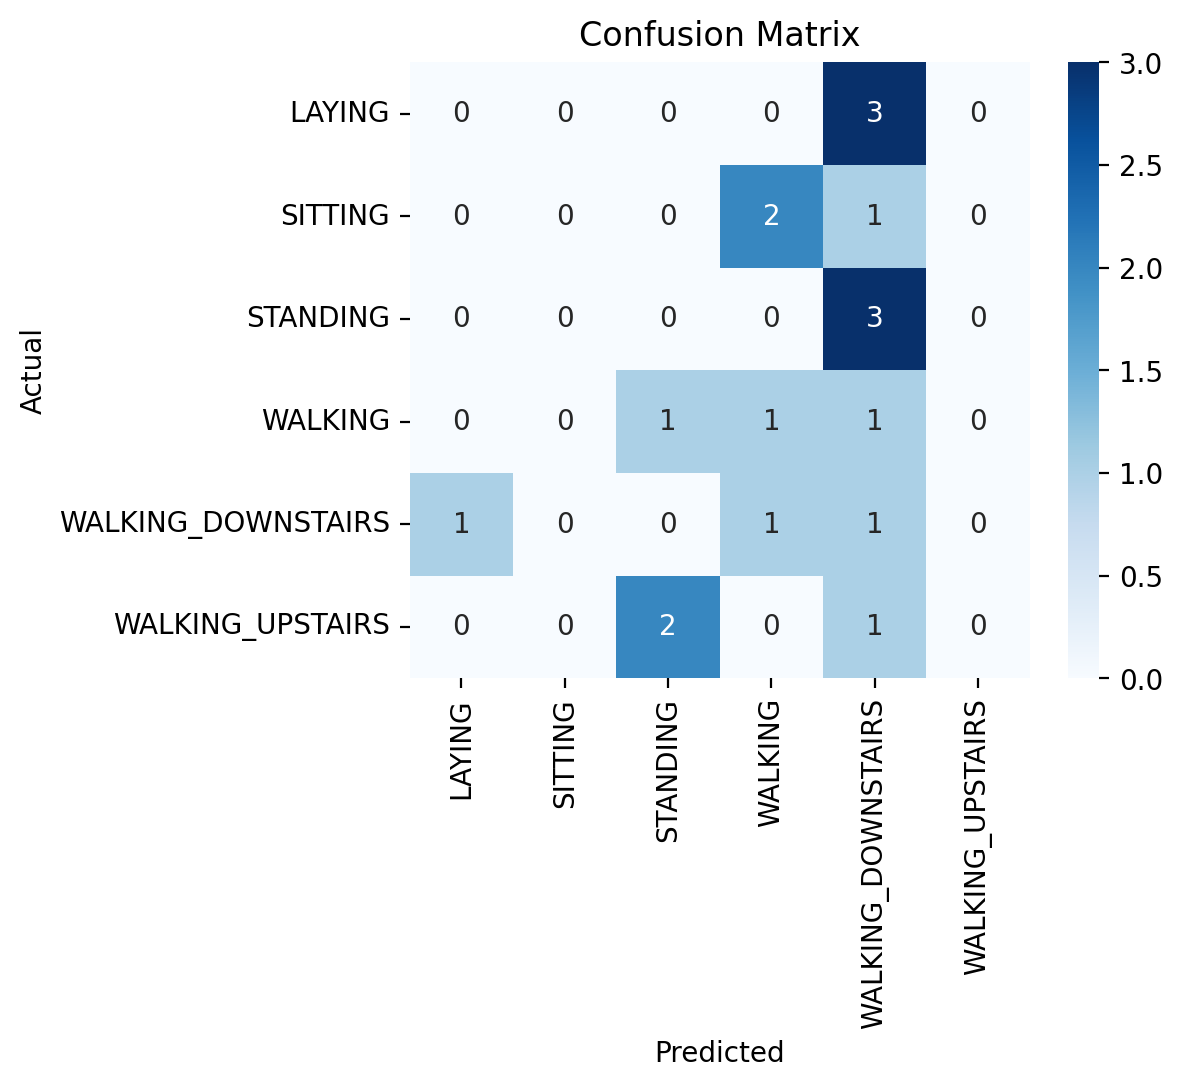

In [ ]:
recorded_data_pred = decision_tree_raw_data.predict(np.array(X_total_acceleration))
print(f"Accuracy = {accuracy_score(y,recorded_data_pred)}")
print(f"Precision = {precision_score(y,recorded_data_pred,average='weighted')}")
print(f"Recall = {recall_score(y,recorded_data_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y,recorded_data_pred,average='weighted')}")
cm = confusion_matrix(y,recorded_data_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [201]:
recorded_data_model = DecisionTreeClassifier()
recorded_data_model.fit(X_total_acceleration[:15], y[:15])
predicts = recorded_data_model.predict(X_total_acceleration[15:])
predicts

array(['STANDING', 'WALKING', 'LAYING'], dtype='<U18')

In [202]:
recorded_tsfel_model = DecisionTreeClassifier()
recorded_tsfel_model.fit(recorded_tsfel_features[:15], y[:15])
prediction_ = recorded_tsfel_model.predict(recorded_tsfel_features[15:])
prediction_

array(['SITTING', 'STANDING', 'SITTING'], dtype='<U18')